# Modeling
In this exercise, we will predict activity on drd1 ligands. We will use regresion forms of [SVM](https://en.wikipedia.org/wiki/Support-vector_machine) and [Random Forest](https://en.wikipedia.org/wiki/Random_forest). This methods are good, but they allways give you some results, so remember garbage in, garbage out. We will use again
scikit [SVR](https://scikit-learn.org/stable/modules/svm.html#regression) and [RF](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html?highlight=random%20forest#sklearn.ensemble.RandomForestRegressor).

In [1]:
from scipy.spatial import distance
from sklearn import manifold
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn import svm
from sklearn import ensemble
from sklearn import model_selection as ms
from sklearn.metrics import mean_squared_error

# rdkit mols are displayed as images
from rdkit.Chem.Draw import IPythonConsole

from rdkit.Chem import AllChem as Chem
from rdkit import DataStructs
from rdkit.Chem.SaltRemover import SaltRemover

# descriptors
from rdkit.Chem import Lipinski
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Descriptors

# plots
from matplotlib import pyplot
import seaborn

# other packages
import pandas as pd
import numpy as np
import csv
import re

RDKit WARNING: [14:20:41] Enabling RDKit 2019.09.3 jupyter extensions


## Standardization

Before we start with model training, we should clean our data - standardize compounds. In our case, it means removal of salts, inorganics and [neutralization](https://rdkit.readthedocs.io/en/latest/Cookbook.html#neutralizing-charged-molecules). You can use tautomerization or some advanced packages like [molvs](https://molvs.readthedocs.io/en/latest/).

In [2]:
sr = SaltRemover() # from rdkit
m = Chem.MolFromSmiles("[Na+].C(=O)[O-]")
print(Chem.MolToSmiles(sr(m)))

O=C[O-]


In [3]:
""" contribution from Hans de Winter """
def _InitialiseNeutralisationReactions():
    patts= (
        # Imidazoles
        ('[n+;H]','n'),
        # Amines
        ('[N+;!H0]','N'),
        # Carboxylic acids and alcohols
        ('[$([O-]);!$([O-][#7])]','O'),
        # Thiols
        ('[S-;X1]','S'),
        # Sulfonamides
        ('[$([N-;X2]S(=O)=O)]','N'),
        # Enamines
        ('[$([N-;X2][C,N]=C)]','N'),
        # Tetrazoles
        ('[n-]','[nH]'),
        # Sulfoxides
        ('[$([S-]=O)]','S'),
        # Amides
        ('[$([N-]C=O)]','N'),
        )
    return [(Chem.MolFromSmarts(x),Chem.MolFromSmiles(y,False)) for x,y in patts]

_reactions=None
def NeutraliseCharges(mol, reactions=None):
    global _reactions
    if reactions is None:
        if _reactions is None:
            _reactions=_InitialiseNeutralisationReactions()
        reactions=_reactions
    replaced = False
    for i,(reactant, product) in enumerate(reactions):
        while mol.HasSubstructMatch(reactant):
            replaced = True
            rms = Chem.ReplaceSubstructs(mol, reactant, product)
            mol = rms[0]
    return mol, replaced

In [4]:
smis=("c1cccc[nH+]1",
      "C[N+](C)(C)C","c1ccccc1[NH3+]",
      "CC(=O)[O-]","c1ccccc1[O-]",
      "CCS",
      "C[N-]S(=O)(=O)C",
      "C[N-]C=C","C[N-]N=C",
      "c1ccc[n-]1",
      "CC[N-]C(=O)CC")
for smi in smis:
    (molSmiles, neutralised) = NeutraliseCharges(Chem.MolFromSmiles(smi))
    print(smi + "->" + Chem.MolToSmiles(molSmiles))

c1cccc[nH+]1->c1ccncc1
C[N+](C)(C)C->C[N+](C)(C)C
c1ccccc1[NH3+]->Nc1ccccc1
CC(=O)[O-]->CC(=O)O
c1ccccc1[O-]->Oc1ccccc1
CCS->CCS
C[N-]S(=O)(=O)C->CNS(C)(=O)=O
C[N-]C=C->C=CNC
C[N-]N=C->C=NNC
c1ccc[n-]1->c1cc[nH]c1
CC[N-]C(=O)CC->CCNC(=O)CC


In [5]:
_saltRemover = SaltRemover()
_inorganicPatt = Chem.MolFromSmarts("[!#6;!#7;!#8;!#16;!F;!Cl;!Br;!I]") # to remove compounds with unwanted atom types
_carbonPatt = Chem.MolFromSmarts("[#6]") # to remove compounds without carbon - inorganic
def standardize(mol):
    if mol.HasSubstructMatch(_carbonPatt):
        mol = _saltRemover(mol)
        if mol.GetNumAtoms()==0:
            return None
        else:
            mol, neutralized = NeutraliseCharges(mol)
            if mol.HasSubstructMatch(_inorganicPatt):
                return None
            else:
                # Sanitize mol, without sanitization some structures can't be drawn or fingerprinted
                Chem.SanitizeMol(mol) # add catch block?
                return mol
    else:
        return None

## Data loading

In [6]:
# some pChEMBL values in our file are not valid floats
float_pattern = re.compile("[0-9]+(\.[0-9]*)?")
# function for Lipinski's descriptors
lip_func = [("HBA", Lipinski.NumHAcceptors), ("HBD", Lipinski.NumHDonors), ("MW", Descriptors.ExactMolWt),
            ("LogP", Descriptors.MolLogP), ("TPSA", rdMolDescriptors.CalcTPSA), ("RB", Lipinski.NumRotatableBonds)]
# load mtor, we want to remember source of data and Standard and pChEMBLE value (it's transfomed compound activity to "standard" value)
with open("DRD1.csv") as inp:
    drd1 = [row for row in csv.DictReader(inp, delimiter=";", quotechar='"')]
    for m in drd1:
        mol = Chem.MolFromSmiles(m["Smiles"])
        if m['Smiles'] != '':
            if mol:
                m["rdmol"] = mol
                stdmol = standardize(mol)
                m["source"] = "drd1"
                m["pChEMBL Value"] = float(m["pChEMBL Value"]) if float_pattern.match(m["pChEMBL Value"]) else 0
                m["std_rdmol"] = None
                m["Standard Value"] = float(m["Standard Value"]) if float_pattern.match(m["Standard Value"]) else np.NaN
            if stdmol:
                m["std_rdmol"] = stdmol
                m["std_smiles"] = Chem.MolToSmiles(stdmol)
                m["fps"] = Chem.GetMorganFingerprintAsBitVect(m["std_rdmol"],2,nBits=1024)
                for f in lip_func:
                    m[f[0]] = f[1](m["std_rdmol"])
        else:
            drd1.remove(m)

In [7]:
for m in drd1:
    try:
        print(m["std_rdmol"])
    except:
        print("An exception occurred")
        m["std_rdmol"] = None

An exception occurred
None
None
An exception occurred
An exception occurred
An exception occurred
None
An exception occurred
An exception occurred
An exception occurred
An exception occurred
None
None
An exception occurred
None
An exception occurred
An exception occurred
None
None
An exception occurred
None
An exception occurred
An exception occurred
None
None
None
None
An exception occurred
An exception occurred
None
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
None
An exception occurred
None
None
None
An exception occurred


In [8]:
%%capture
# %%capture hides stderr (and maybe all output)
# same for drugbank
drugbank = []
for m in Chem.SDMolSupplier("../data/drugbank.sdf"):
    if m:
        stdmol = standardize(m)
    else:
        continue    
    if stdmol:
        std_smiles = Chem.MolToSmiles(stdmol)
        drugbank.append({
         "rdmol": m,
         "std_rdmol": stdmol,
         "source": "drugbank",
         "std_smiles": std_smiles,
         "Smiles": Chem.MolToSmiles(m),
         "pChEMBL Value": 0,
         "Standard Value": np.NaN,
         "fps": Chem.GetMorganFingerprintAsBitVect(stdmol, 2, nBits=1024),
         **{f[0]: f[1](stdmol) for f in lip_func}
        })


In [9]:
# let's work with Pandas dataframe
df = pd.DataFrame((*drugbank, *[m for m in drd1 if m["std_rdmol"]]), columns=["Smiles", "std_smiles", "source", "rdmol", "std_rdmol", "fps", "Standard Value", "pChEMBL Value", *(f[0] for f in lip_func)])
# adds index as normal column
# MQN = molecular quantum numbers
df.reset_index(level=0, inplace=True)
df = df.join(pd.DataFrame((rdMolDescriptors.MQNs_(mol) for mol in df["std_rdmol"]),
                          columns=[*(f"MQN_{x}" for x in range(1,43))])
            )


In [10]:
mx = df["Standard Value"].max()+1
df["Standard Value"] = df["Standard Value"].fillna(mx+1)

## SVR

In [11]:
svr = svm.SVR()
svr.fit(df[df["Standard Value"]<mx][(f"MQN_{x}" for x in range(1, 43))], df[df["Standard Value"]<mx]["Standard Value"])

SVR()

In [12]:
res = pd.DataFrame(svr.predict(df[(f"MQN_{x}" for x in range(1, 43))])).join(df[["Standard Value", "source"]])
res.columns = ["Prediction", "Standard Value", "Source"]
(res["Prediction"]-res["Standard Value"]).abs().mean()

95234.87563810566

In [13]:
(res[res["Source"]=="drd1"]["Prediction"]-res[res["Source"]=="drd1"]["Standard Value"]).abs().mean()

75231.35815668188

### Let's use some function to get results, we will have lots of models

In [14]:
def get_results(model, data, descriptors, predicted_value):
    res = pd.DataFrame(model.predict(data[descriptors])).join(data[[predicted_value, "source"]])
    res.columns = ["Prediction", predicted_value, "Source"]
    print(f"""Average error whole set: {(res["Prediction"]-res[predicted_value]).abs().mean()}
Average error drd1: {(res[res["Source"]=="drd1"]["Prediction"]-res[res["Source"]=="drd1"][predicted_value]).abs().mean()}""")
    return res

In [15]:
res = get_results(svr, df, (f"MQN_{x}" for x in range(1, 43)), "Standard Value")

Average error whole set: 95234.87563810566
Average error drd1: 75231.35815668188


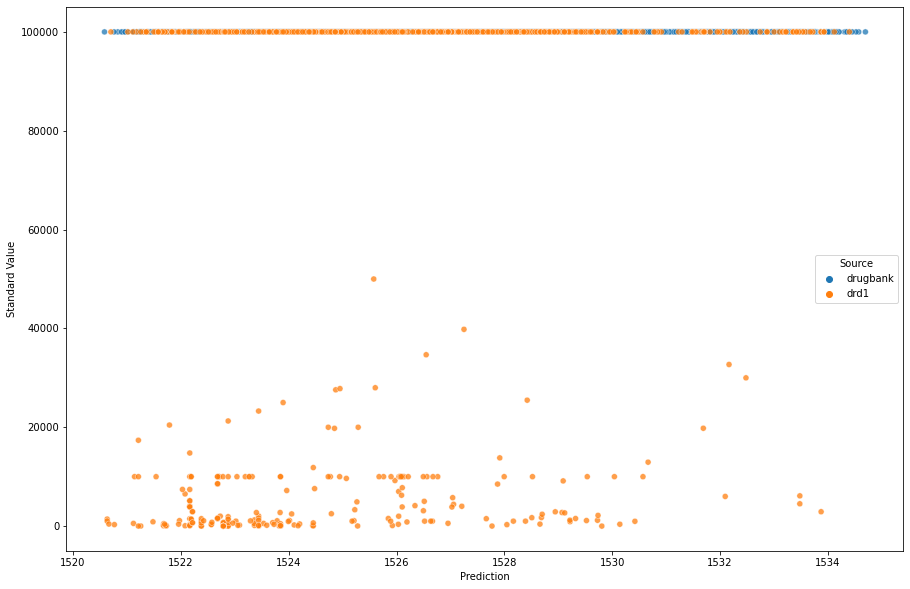

In [16]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="Standard Value",
                      data=res,
                      hue="Source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

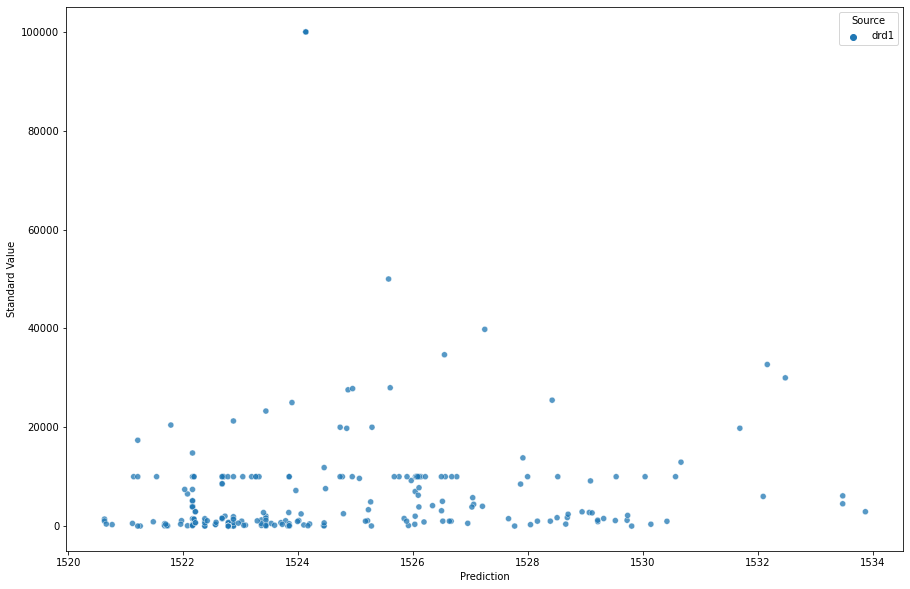

In [17]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="Standard Value",
                      data=res[res["Standard Value"]<mx],
                      hue="Source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

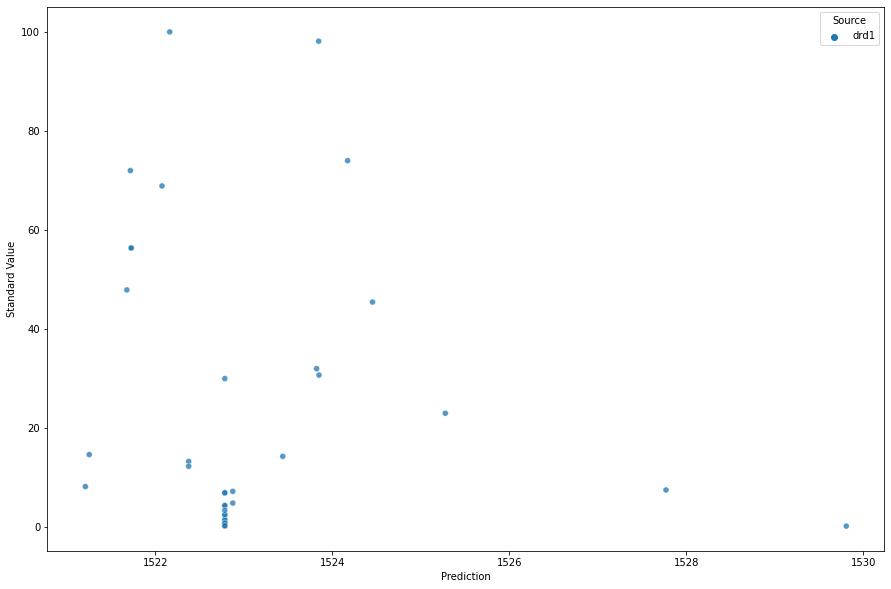

In [18]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="Standard Value",
                      data=res[res["Standard Value"]<mx/1000],
                      hue="Source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

## Random forest

In [19]:
rf = ensemble.RandomForestRegressor()
rf.fit(df[df["Standard Value"]<mx][(f"MQN_{x}" for x in range(1, 43))], df[df["Standard Value"]<mx]["Standard Value"])

RandomForestRegressor()

In [20]:
res_rf = get_results(rf, df, (f"MQN_{x}" for x in range(1, 43)), "Standard Value")

Average error whole set: 85937.64631678986
Average error drd1: 67329.09722259983


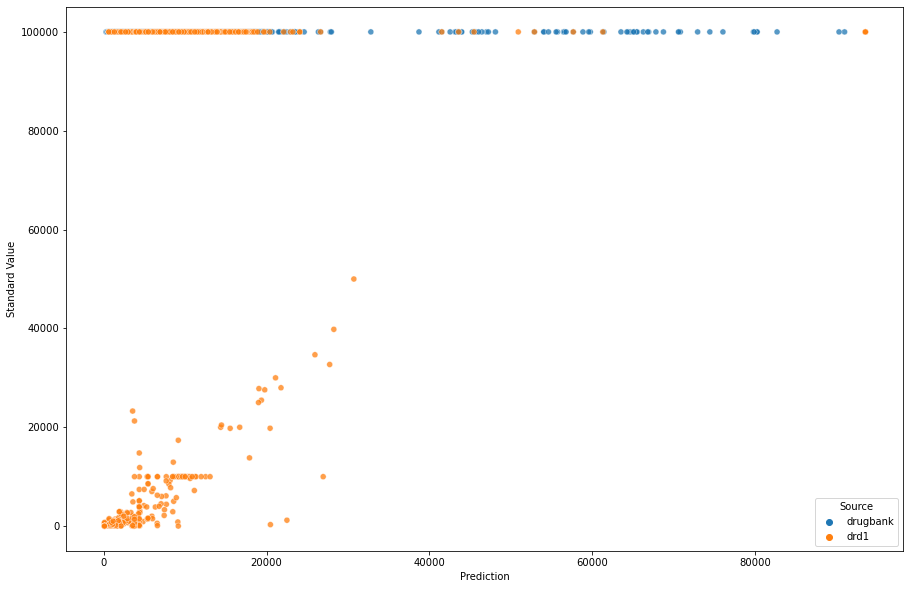

In [21]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="Standard Value",
                      data=res_rf,
                      hue="Source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

C:\Users\elieb\miniconda3\envs\cdd\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


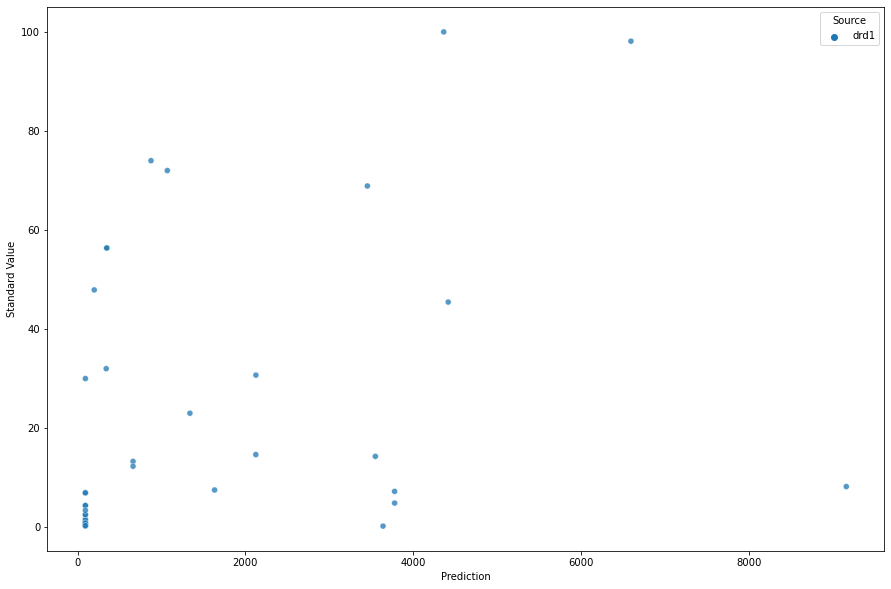

In [22]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="Standard Value",
                      data=res_rf[res_rf["Standard Value"]<mx/1000][res_rf["Prediction"]<1e6],
                      hue="Source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

You can see the range of values is pretty broad. Maybe, log values will be better. Let's try pChEMBL Value.

# PCHEMBL
## SVR

In [23]:
svr_p = svm.SVR()
svr_p.fit(df[df["pChEMBL Value"]>0][(f"MQN_{x}" for x in range(1, 43))], df[df["pChEMBL Value"]>0]["pChEMBL Value"])

SVR()

In [24]:
res_svr_p = get_results(svr_p, df, (f"MQN_{x}" for x in range(1, 43)), "pChEMBL Value")

Average error whole set: 5.706413574104179
Average error drd1: 4.93133774091559


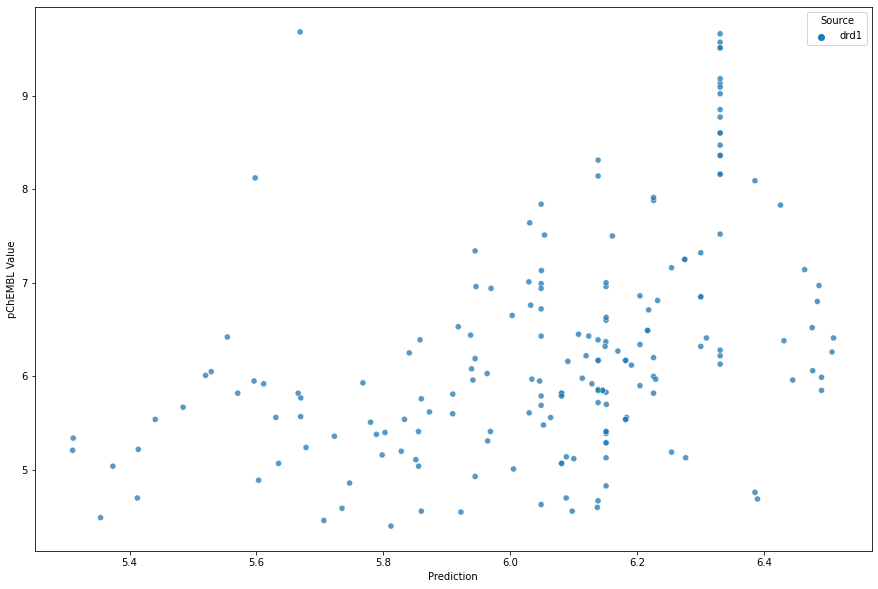

In [25]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="pChEMBL Value",
                      data=res_svr_p[res_svr_p["pChEMBL Value"]>0],
                      hue="Source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

## SVR with PCA

In [26]:
norm = preprocessing.normalize(df[(f"MQN_{x}" for x in range(1, 43))])
pca = decomposition.PCA(n_components=42)
pca.fit(norm)
df = df.join(pd.DataFrame(pca.transform(norm), columns=[f"nPCA_{x}" for x in range(1, 43)]))

In [27]:
svr_np = svm.SVR()
svr_np.fit(df[df["Standard Value"]<mx][(f"nPCA_{x}" for x in range(1, 43))], df[df["Standard Value"]<mx]["pChEMBL Value"])

SVR()

In [28]:
res_svr_np = res = get_results(svr_np, df, (f"nPCA_{x}" for x in range(1, 43)), "pChEMBL Value")

Average error whole set: 4.5768753446054085
Average error drd1: 3.9853042277309405


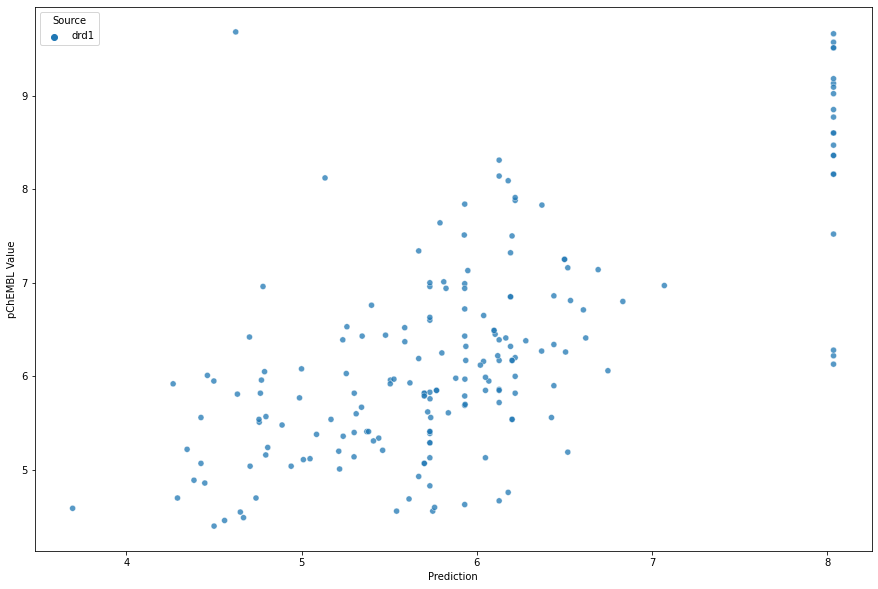

In [29]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="pChEMBL Value",
                      data=res_svr_np[res_svr_np["pChEMBL Value"]>0],
                      hue="Source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

## SVR with other kernel


In [30]:
svr_poly = svm.SVR(kernel='poly')
svr_poly.fit(df[df["Standard Value"]<mx][(f"nPCA_{x}" for x in range(1, 43))], df[df["Standard Value"]<mx]["pChEMBL Value"])

SVR(kernel='poly')

In [31]:
res_poly = get_results(svr_poly, df, (f"nPCA_{x}" for x in range(1, 43)), "pChEMBL Value")

Average error whole set: 4.6552408463677
Average error drd1: 4.02530013621382


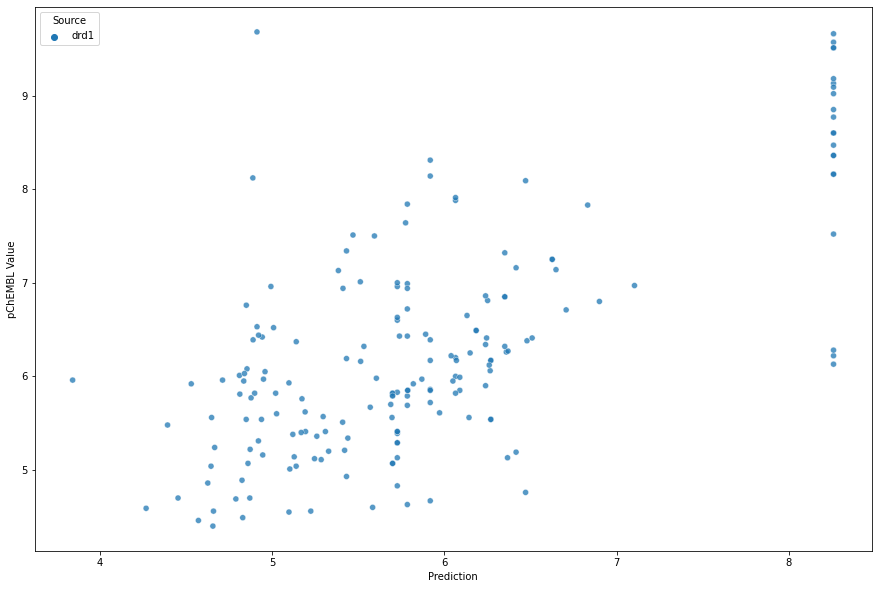

In [32]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="pChEMBL Value",
                      data=res_poly[res_poly["pChEMBL Value"]>0],
                      hue="Source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

## RF with pChEMBL Value

In [50]:
rf_poly = ensemble.RandomForestRegressor()
rf_poly.fit(df[df["pChEMBL Value"]<mx][(f"MQN_{x}" for x in range(1, 43))], df[df["pChEMBL Value"]<mx]["pChEMBL Value"])

RandomForestRegressor()

In [51]:
res_rf_poly = get_results(rf_poly, df, (f"MQN_{x}" for x in range(1, 43)), "pChEMBL Value")

Average error whole set: 0.097690446804803
Average error drd1: 0.39736999179965704


whole set vs drd1 difference?!

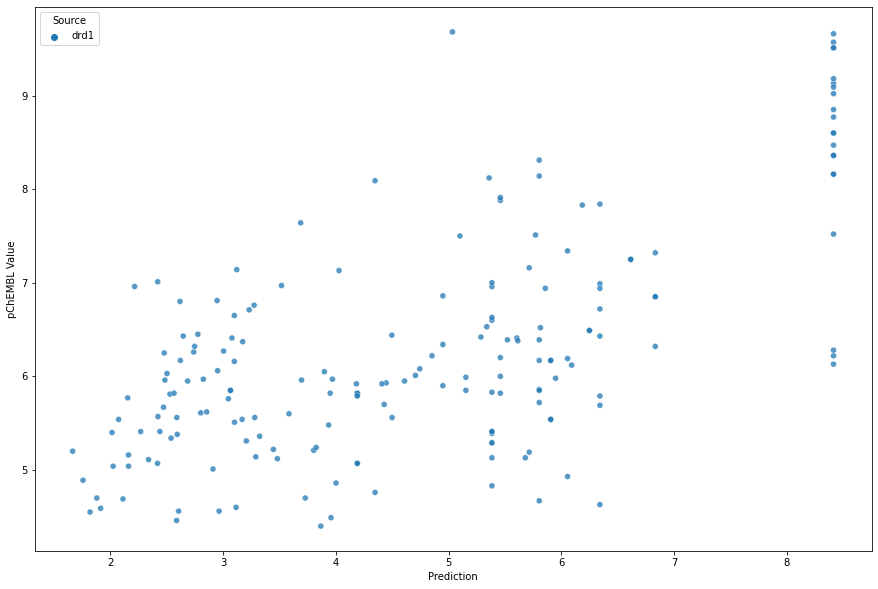

In [52]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="pChEMBL Value",
                      data=res_rf_poly[res_rf_poly["pChEMBL Value"]>0],
                      hue="Source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

## We need test set
So, we divide our data in some ration (default is 75:25, but 80:20-70:30 is usually OK)

In [33]:
trainset, testset = ms.train_test_split(df[df["pChEMBL Value"]>0])

In [34]:
trainset.reset_index(inplace=True)
testset.reset_index(inplace=True)

In [35]:
len(trainset), len(testset)

(141, 47)

### RF

In [36]:
finaly_good_model = ensemble.RandomForestRegressor()
finaly_good_model.fit(trainset[(f"MQN_{x}" for x in range(1, 43))], trainset["pChEMBL Value"])

RandomForestRegressor()

In [37]:
train_results = get_results(finaly_good_model, trainset, (f"MQN_{x}" for x in range(1, 43)), "pChEMBL Value")

Average error whole set: 0.46131189233042696
Average error drd1: 0.46131189233042696


In [38]:
test_results = get_results(finaly_good_model, testset, (f"MQN_{x}" for x in range(1, 43)), "pChEMBL Value")

Average error whole set: 0.5725842293477174
Average error drd1: 0.5725842293477174


In [39]:
print("R^2: %0.2f" % finaly_good_model.score(testset[(f"MQN_{x}" for x in range(1, 43))], testset["pChEMBL Value"]))
print("R: %0.2f" % np.sqrt(finaly_good_model.score(testset[(f"MQN_{x}" for x in range(1, 43))], testset["pChEMBL Value"])))
print("MSE: %0.2f" %  mean_squared_error(test_results["Prediction"], test_results["pChEMBL Value"]))

R^2: 0.62
R: 0.79
MSE: 0.56


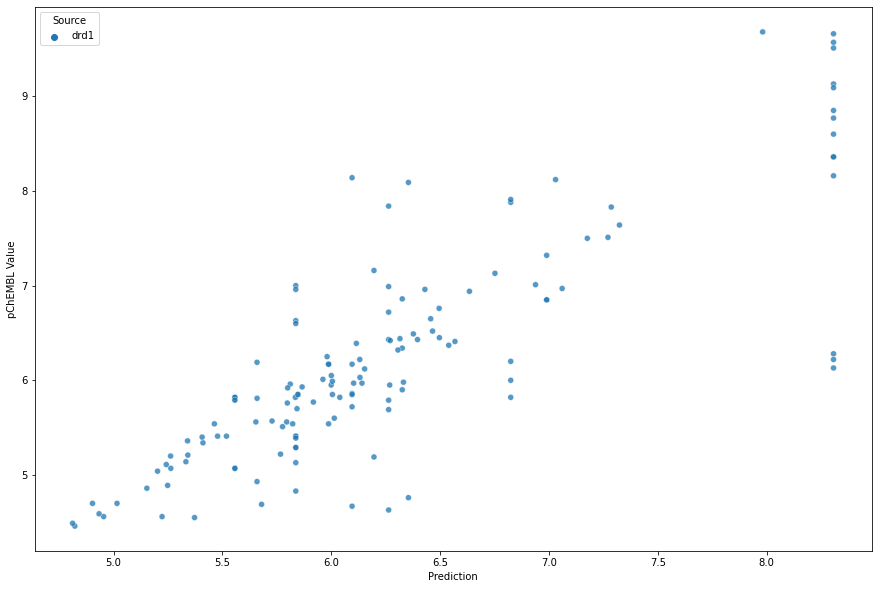

In [40]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="pChEMBL Value",
                      data=train_results,
                      hue="Source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

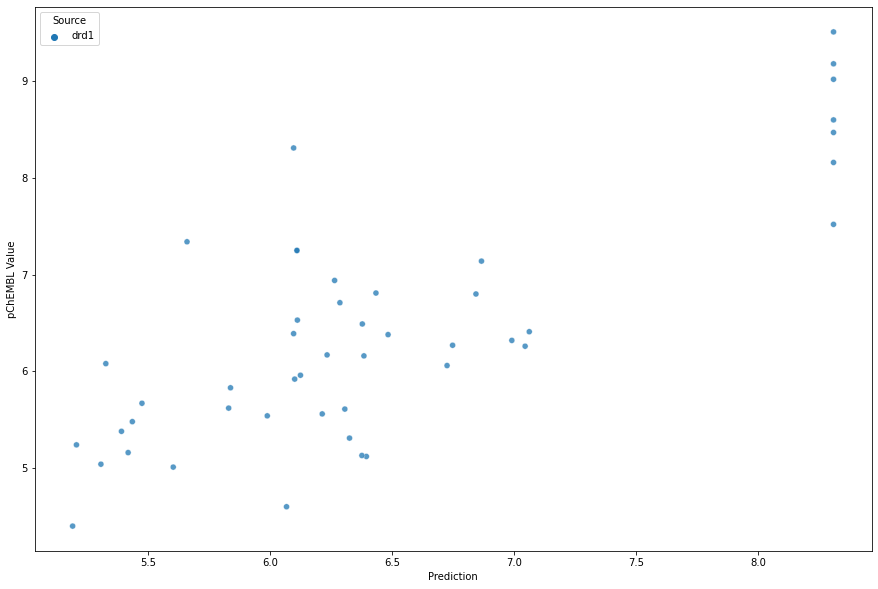

In [41]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="pChEMBL Value",
                      data=test_results,
                      hue="Source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

### RF + PCA

## What to do?
* Familiarize yourself with modeling. If mentioned models in this exercise are not enough, you can surely find more methods in scikit-learn. You can use another descriptors, e.g. fingerprints.
* Find some well predictig solution set of model and descriptors on your data